## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Relu

In [2]:
# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4536) 
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(epoch)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Complete!")

Epoch 1/5, Loss: 1.3935
Epoch 2/5, Loss: 1.0238
Epoch 3/5, Loss: 0.8689
Epoch 4/5, Loss: 0.7606
Epoch 5/5, Loss: 0.6678
Training Complete!


In [5]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 74.25%


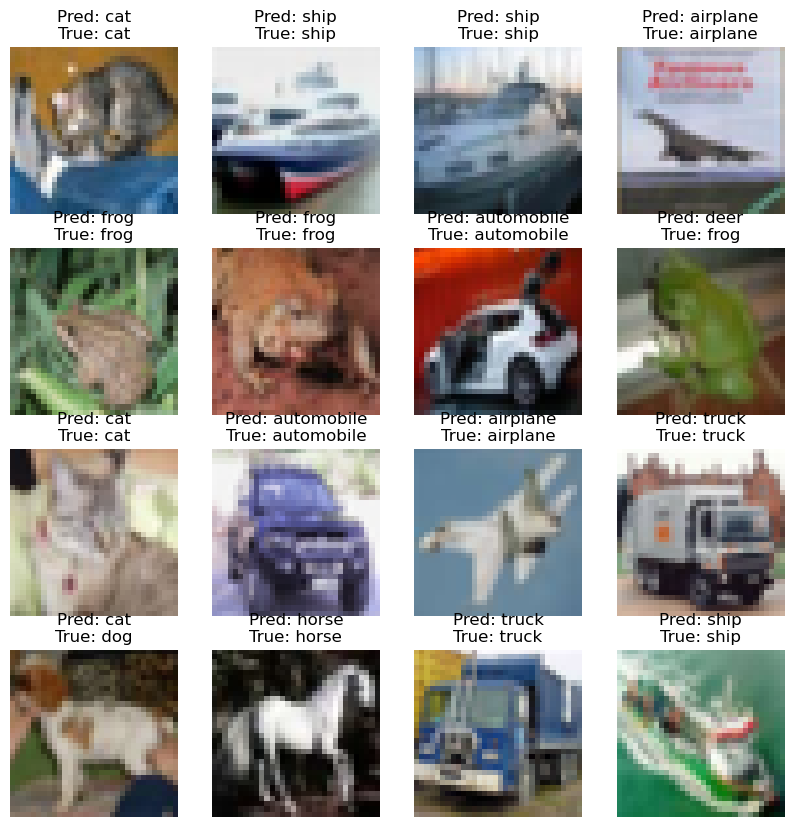

In [6]:
# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Show images with predicted labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
classes = trainset.classes
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy image
    img = img * 0.5 + 0.5  # Undo normalization
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis("off")

plt.show()

## ELU

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2526)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.alpha = 0.0723

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))  # ELU
        x = self.pool(F.elu(self.conv2(x)))  # ELU
        x = x.view(x.size(0), -1)
        x = self.dropout(F.elu(self.fc1(x), alpha=self.alpha)) 
        #x = F.elu(self.fc1(x))  # ELU
        x = self.fc2(x)
        return x

In [14]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Complete!")

Epoch 1/5, Loss: 1.2212
Epoch 2/5, Loss: 0.8525
Epoch 3/5, Loss: 0.6513
Epoch 4/5, Loss: 0.4903
Epoch 5/5, Loss: 0.3625
Training Complete!


In [16]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 73.23%


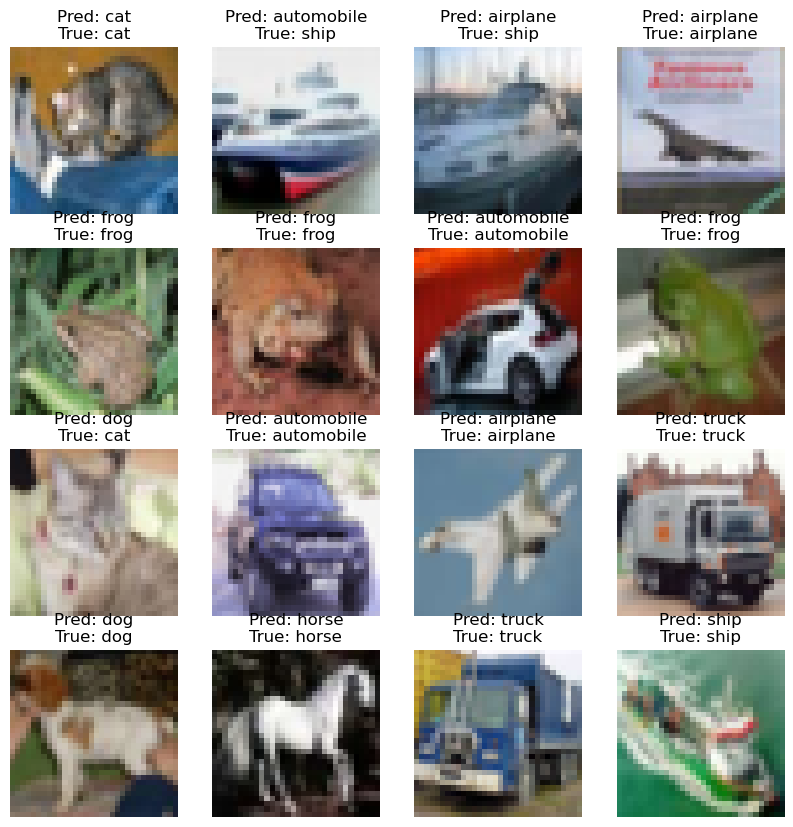

In [17]:
# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Show images with predicted labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
classes = trainset.classes
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy image
    img = img * 0.5 + 0.5  # Undo normalization
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis("off")

plt.show()


## Leaky Relu

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2511) 
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.negative_slope = 0.0121 

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))  # LeakyReLU
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))  # LeakyReLU
        x = x.view(x.size(0), -1)
        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=self.negative_slope))
        #x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  # LeakyReLU
        x = self.fc2(x)
        return x

In [19]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Complete!")

Epoch 1/5, Loss: 1.3765
Epoch 2/5, Loss: 1.0105
Epoch 3/5, Loss: 0.8607
Epoch 4/5, Loss: 0.7466
Epoch 5/5, Loss: 0.6465
Training Complete!


In [21]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 72.31%


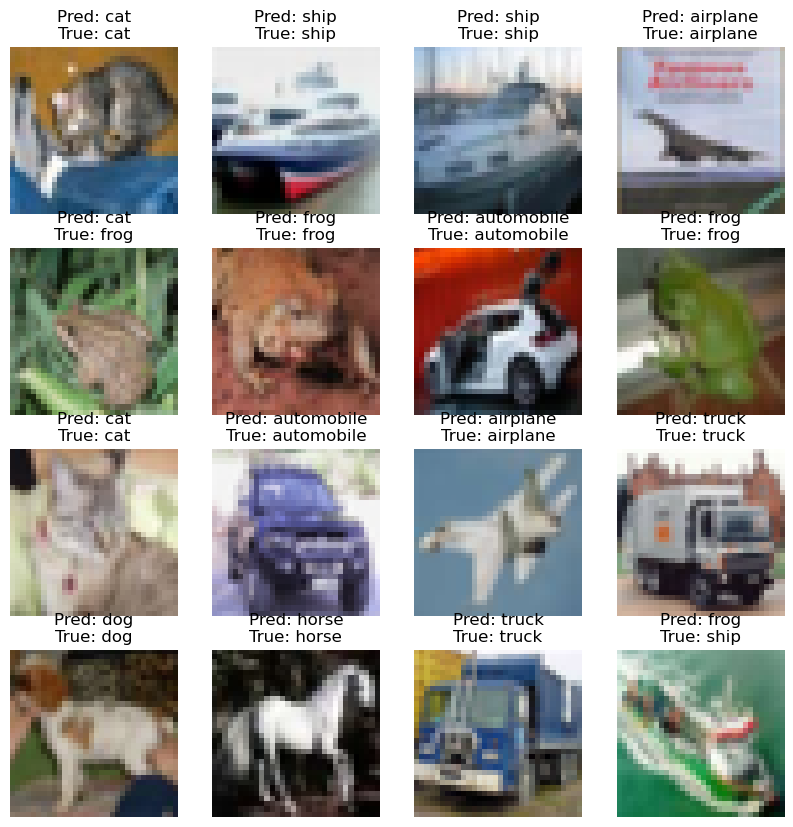

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Show images with predicted labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
classes = trainset.classes
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy image
    img = img * 0.5 + 0.5  # Undo normalization
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis("off")

plt.show()

Relu has the highest accuracy rate, now let's try different poolings

# Pooling

## Average Pooling

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.4536) 
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [24]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(64 * 8 * 8, 256)
#         self.fc2 = nn.Linear(256, 10)

#     def forward(self, x):
#         x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))  # LeakyReLU
#         x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))  # LeakyReLU
#         x = x.view(x.size(0), -1)
#         x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  # LeakyReLU
#         x = self.fc2(x)
#         return x

In [25]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Complete!")

Epoch 1/5, Loss: 1.4384
Epoch 2/5, Loss: 1.1005
Epoch 3/5, Loss: 0.9367
Epoch 4/5, Loss: 0.8264
Epoch 5/5, Loss: 0.7361
Training Complete!


In [29]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 71.23%


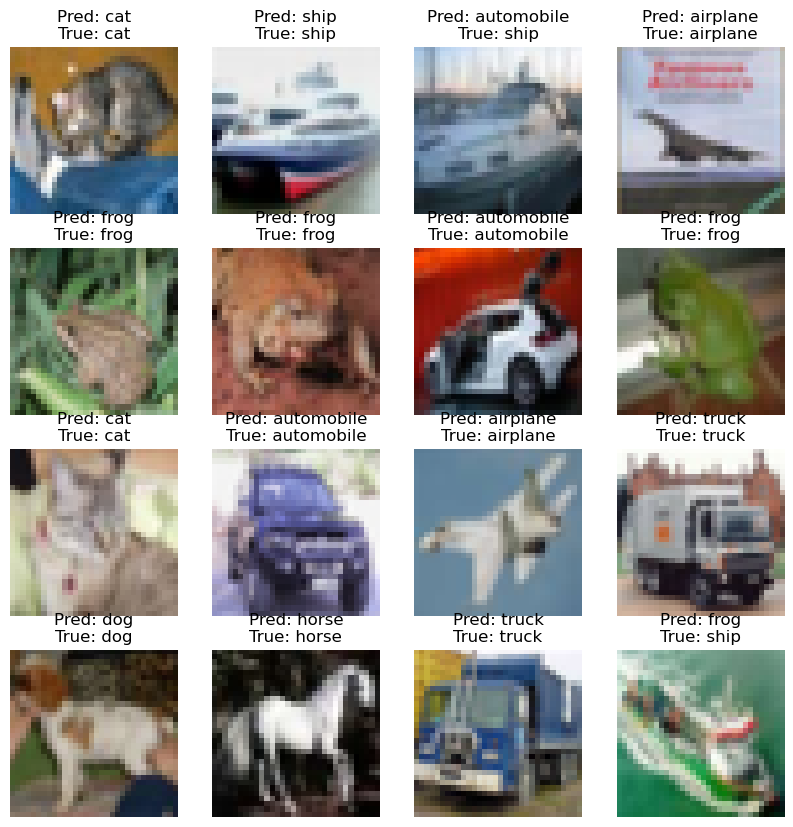

In [30]:
# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Show images with predicted labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
classes = trainset.classes
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy image
    img = img * 0.5 + 0.5  # Undo normalization
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis("off")

plt.show()

## Adaptive Pooling

In [31]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 3, padding=1)
        self.pool = nn.AdaptiveMaxPool2d((4, 4))
        self.dropout = nn.Dropout(0.4536) 
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [32]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Complete!")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4096 and 16384x256)

In [34]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4096 and 16384x256)

In [ ]:
# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# Show images with predicted labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
classes = trainset.classes
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy image
    img = img * 0.5 + 0.5  # Undo normalization
    ax.imshow(img)
    ax.set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    ax.axis("off")

plt.show()